# Part 0: Data Preparation





In [ ]:
!pip install lime

In [29]:
import pandas as pd 
import numpy as np 

## visualization 
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import seaborn as sns 
from PIL import Image

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = [16, 10]
mpl.rcParams['axes.prop_cycle']

from tqdm import tqdm # import tqdm
tqdm.pandas() # initialize tqdm for pandas

## Preprocessing 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import feature_extraction
import string 
punct =string.punctuation
import re

## Modelization 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.metrics import classification_report

## lime explainer 
from lime.lime_text import LimeTextExplainer
from collections import OrderedDict

## word embeddings 
import gensim
from sklearn import manifold 
# from mpl_toolkits.mplot3d import Axes3D

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

## Word embedding models 
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/FOOD/

/content/drive/MyDrive/FOOD


## Training Data

In [ ]:
inter_train = pd.read_csv('interactions_train.csv')
inter_train.head(5)

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


We reate a new column called _year_ and use seaborn to plot the number of recipes per year.

Text(0.5, 1.0, 'Number of recipes by year')

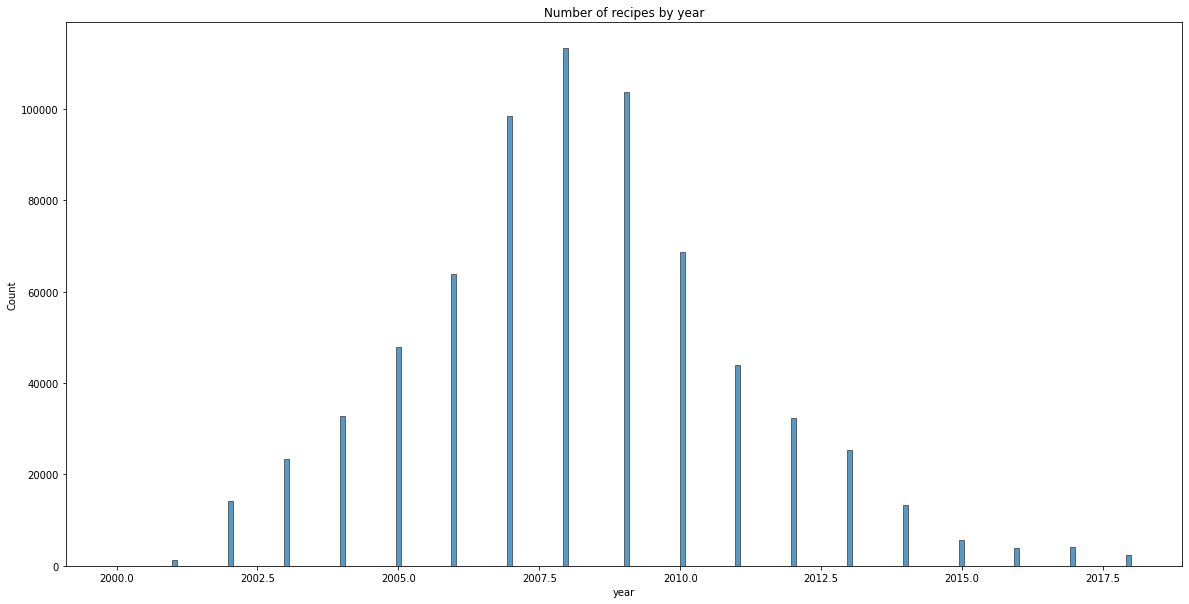

In [ ]:
inter_train['year'] = pd.DatetimeIndex(inter_train['date']).year

plt.figure(figsize=(20,10))
sns.histplot(data=inter_train, x="year")
plt.title('Number of recipes by year')

In [ ]:
raw_recipes = pd.read_csv('RAW_recipes.csv')
raw_recipes.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


We reate a new column called _year_ and use seaborn to plot the number of recipes submitted per year.

Text(0.5, 1.0, 'Number of recipes submitted by year')

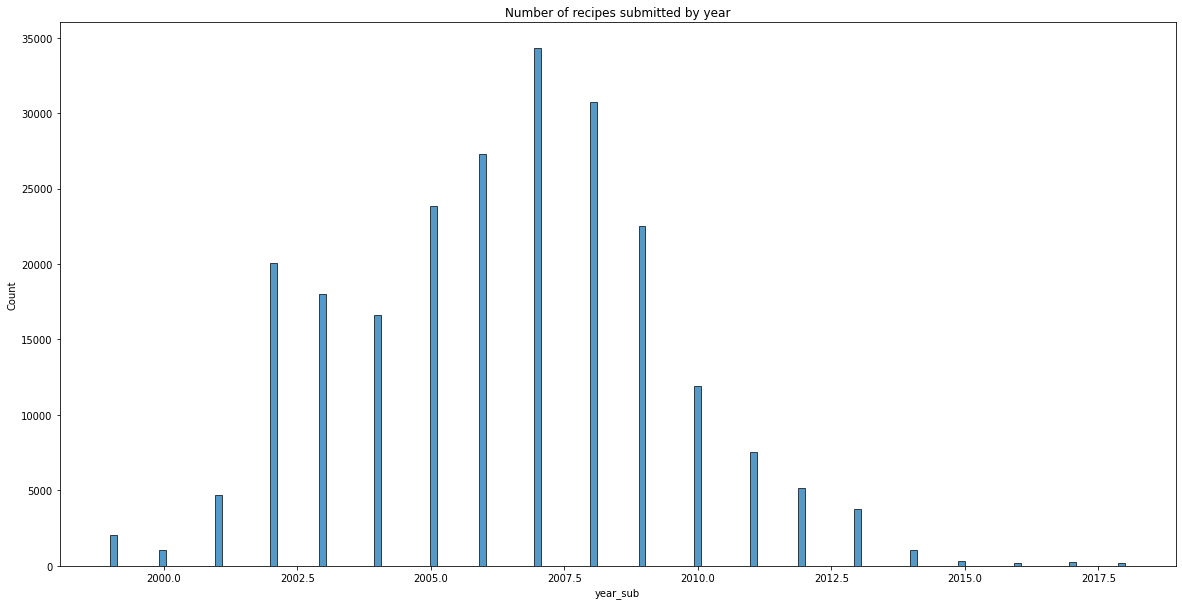

In [ ]:
raw_recipes['year_sub'] = pd.DatetimeIndex(raw_recipes['submitted']).year

plt.figure(figsize=(20,10))
sns.histplot(data=raw_recipes, x="year_sub")
plt.title('Number of recipes submitted by year')

In [ ]:
raw_inter = pd.read_csv('RAW_interactions.csv')
raw_inter.head(5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


We reate a new column called _year_inter_ and use seaborn to plot the number of recipes with interactions per year.

Text(0.5, 1.0, 'Number of recipes with interactions by year')

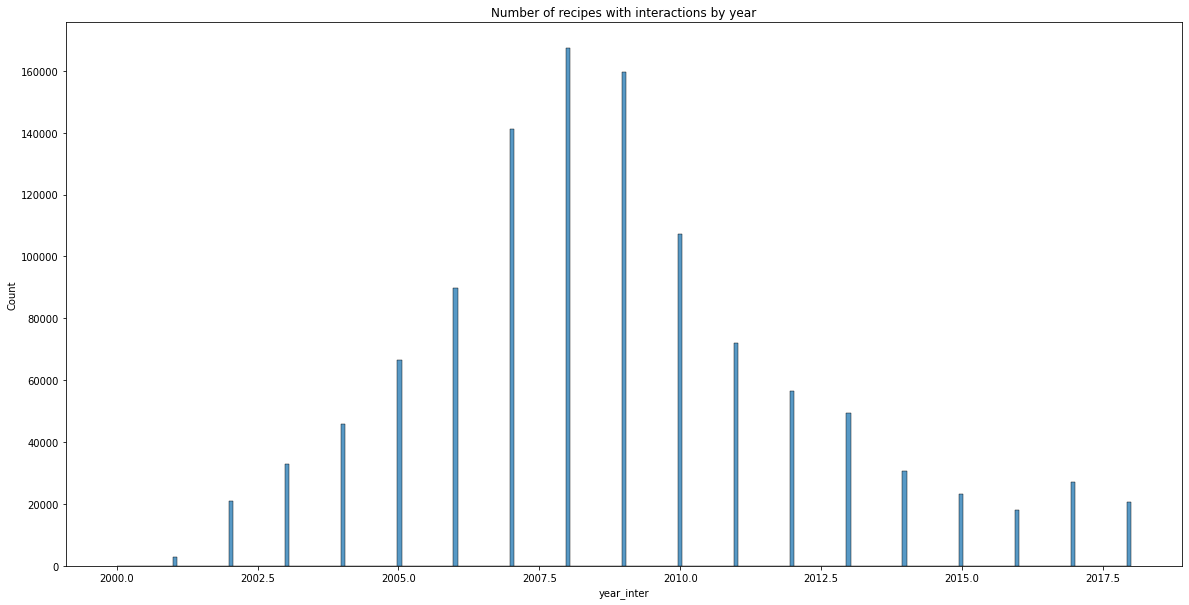

In [ ]:
raw_inter['year_inter'] = pd.DatetimeIndex(raw_inter['date']).year

plt.figure(figsize=(20,10))
sns.histplot(data=raw_inter, x="year_inter")
plt.title('Number of recipes with interactions by year')

In [ ]:
print('The total number of recipes submitted is ', raw_recipes.id.unique().shape[0])
print('The total number of recipes with interactions is ', raw_inter.recipe_id.unique().shape[0])
print('The total number of recipes in the training set is ', inter_train.recipe_id.unique().shape[0])

The total number of recipes submitted is  231637
The total number of recipes with interactions is  231637
The total number of recipes in the training set is  160901


In [ ]:
print('The whole recipes submitted and those with interactions are the same: ', set(raw_inter.recipe_id.unique())==set(raw_recipes.id.unique()))

The whole recipes submitted and those with interactions are the same:  True


From the datasets of the recipes and the interactions, we extract those whose ids are in the training dataset and we merge them all to get a final complete training set.

In [ ]:
mask_raw_recipes = raw_recipes.id.isin(inter_train.recipe_id)
new_raw_recipes = raw_recipes[mask_raw_recipes]
mask_raw_inter = raw_inter.recipe_id.isin(inter_train.recipe_id)
new_raw_inter = raw_inter[mask_raw_inter]

In [ ]:
print('The obtained recipes submitted and those in the training are the same: ',set(new_raw_recipes.id.unique())==set(inter_train.recipe_id.unique()))
print('The obtained recipes with interactions and those in the training set are the same: ',set(new_raw_inter.recipe_id.unique())==set(inter_train.recipe_id.unique()))

The obtained recipes submitted and those in the training are the same:  True
The obtained recipes with interactions and those in the training set are the same:  True


In [ ]:
new_raw_recipes.rename(columns={'id': 'recipe_id'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
new_raw_recipes.columns

Index(['name', 'recipe_id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'year_sub'],
      dtype='object')

In [ ]:
inter_train.columns

Index(['user_id', 'recipe_id', 'date', 'rating', 'u', 'i', 'year'], dtype='object')

In [ ]:
new_raw_inter.columns

Index(['user_id', 'recipe_id', 'date', 'rating', 'review', 'year_inter'], dtype='object')

In [ ]:
new_raw_inter.rename(columns={'year_inter': 'year'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
subset = ['recipe_id', 'year', 'rating', 'user_id', 'date']
train_interactions = pd.merge(inter_train, new_raw_inter, on=subset, how='inner')
train_interactions = train_interactions.sort_values('rating', ascending=False).drop_duplicates(subset=subset)
train_interactions.reset_index(drop=True, inplace=True)
train_interactions.head()

,user_id,recipe_id,date,rating,u,i,year,review
0,2046,4684,2000-02-25,5.0,22095,44367,2000,this is absolutely delicious. i even served i...
1,185926,53892,2009-05-03,5.0,2144,84490,2009,"This is soft and delicious, I don't know how i..."
2,1105991,278225,2009-05-03,5.0,1280,169925,2009,"Oh Pat, This was truely outstanding! The balan..."
3,477411,359199,2009-05-03,5.0,1273,42462,2009,"Used .40 lb steak, added more veggies, instead..."
4,1006526,135350,2009-05-04,5.0,21025,164596,2009,I gave up the blue box several years ago and h...


In [ ]:
train_final = pd.merge(train_interactions, new_raw_recipes, on='recipe_id', how='inner')
train_final = train_final.sort_values('rating', ascending=False).drop_duplicates(subset='recipe_id')
train_final.reset_index(drop=True, inplace=True)
train_final.head()

,user_id,recipe_id,date,rating,u,i,year,review,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,year_sub
0,2046,4684,2000-02-25,5.0,22095,44367,2000,this is absolutely delicious. i even served i...,flank steak with lime chipotle sauce,75,1533,1999-11-18,"['time-to-make', 'course', 'main-ingredient', ...","[487.8, 16.0, 283.0, 13.0, 52.0, 20.0, 26.0]",6,"['mix honey with chilies , mustard , lime juic...",yum,"['flank steaks', 'honey', 'chipotle chiles in ...",10,1999
1,251917,298335,2008-06-24,5.0,1217,175617,2008,ZWT4: Excellent! We used our 2 hr Insta-bread ...,seeded whole wheat buttermilk bread bread mac...,190,486725,2008-04-14,"['time-to-make', 'course', 'preparation', 'occ...","[190.7, 5.0, 17.0, 15.0, 11.0, 2.0, 11.0]",6,['place all ingredients in bread machine pan i...,this is an adaptation of a recipe i made from ...,"['buttermilk', 'water', 'olive oil', 'salt', '...",12,2008
2,679719,25329,2008-06-27,5.0,3021,171878,2008,I just got done eating this Mac and cheese. I...,macaroni and cheese 4 389,25,26278,2002-04-16,"['30-minutes-or-less', 'time-to-make', 'main-i...","[390.9, 25.0, 19.0, 14.0, 29.0, 49.0, 15.0]",9,"['cook macaroni , rinse and drain', 'melt butt...",re: the title. just a little joke with so many...,"['butter', 'flour', 'whole milk', 'salt', 'pep...",10,2002
3,570804,173320,2008-06-27,5.0,291,101333,2008,I have an almost identical recipe to this that...,raspberry almond coffee cake,60,68460,2006-06-17,"['60-minutes-or-less', 'time-to-make', 'course...","[181.8, 6.0, 75.0, 6.0, 7.0, 11.0, 10.0]",17,"['preheat oven to 350', 'combine raspberries a...",this is a recipe from my mom and i've had to b...,"['fresh raspberry', 'brown sugar', 'flour', 's...",15,2006
4,260588,46476,2006-02-08,5.0,22554,53559,2006,I was surprised how good this dish is. I did c...,cranberry wild rice pilaf,55,37636,2002-11-17,"['60-minutes-or-less', 'time-to-make', 'course...","[454.4, 19.0, 95.0, 2.0, 17.0, 21.0, 27.0]",11,"['in a large saucepan , bring 6 cups of the br...",a lovely long grain and wild rice pilaf with t...,"['vegetable broth', 'wild rice', 'butter', 'on...",14,2002


In [ ]:
train_final.columns

Index(['user_id', 'recipe_id', 'date', 'rating', 'u', 'i', 'year', 'review',
       'name', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'year_sub'],
      dtype='object')

## Test Data

In [ ]:
test = pd.read_csv('interactions_test.csv')
test.head()

,user_id,recipe_id,date,rating,u,i
0,8937,44551,2005-12-23,4.0,2,173538
1,56680,126118,2006-10-07,4.0,16,177847
2,349752,219596,2008-04-12,0.0,26,89896
3,628951,82783,2007-11-13,2.0,45,172637
4,92816,435013,2013-07-31,3.0,52,177935


We reate a new column called _year_ and use seaborn to plot the number of recipes per year.

Text(0.5, 1.0, 'Number of recipes by year')

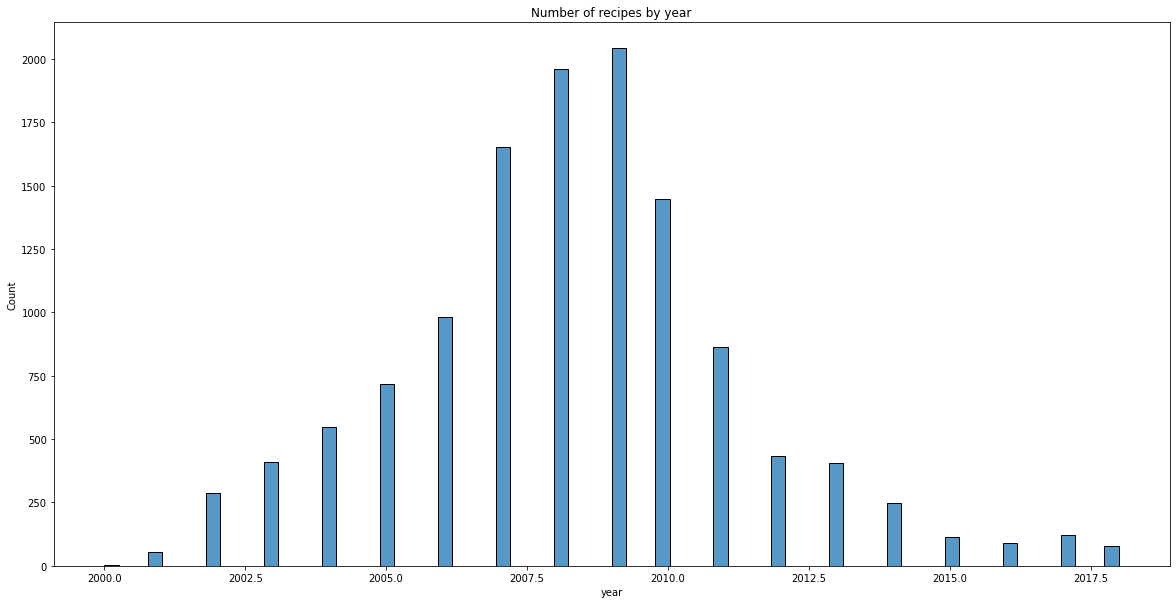

In [ ]:
test['year'] = pd.DatetimeIndex(test['date']).year

plt.figure(figsize=(20,10))
sns.histplot(data=test, x="year")
plt.title('Number of recipes by year')

In [ ]:
print('The total number of recipes submitted is ', raw_recipes.id.unique().shape[0])
print('The total number of recipes with interactions is ', raw_inter.recipe_id.unique().shape[0])
print('The total number of recipes in the test set is ', test.recipe_id.unique().shape[0])

The total number of recipes submitted is  231637
The total number of recipes with interactions is  231637
The total number of recipes in the test set is  11695


From the datasets of the recipes and the interactions, we extract those whose ids are in the test dataset and we merge them all to get a final complete test set.

In [ ]:
mask_raw_recipes = raw_recipes.id.isin(test.recipe_id)
new_raw_recipes_test = raw_recipes[mask_raw_recipes]
mask_raw_inter = raw_inter.recipe_id.isin(test.recipe_id)
new_raw_inter_test = raw_inter[mask_raw_inter]

In [ ]:
print('The obtained recipes submitted and those in the test set are the same: ',set(new_raw_recipes_test.id.unique())==set(test.recipe_id.unique()))
print('The obtained recipes with interactions and those in the test set are the same: ',set(new_raw_inter_test.recipe_id.unique())==set(test.recipe_id.unique()))

The obtained recipes submitted and those in the test set are the same:  True
The obtained recipes with interactions and those in the test set are the same:  True


In [ ]:
new_raw_recipes_test.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'year_sub'],
      dtype='object')

In [ ]:
new_raw_inter_test.columns

Index(['user_id', 'recipe_id', 'date', 'rating', 'review', 'year_inter'], dtype='object')

In [ ]:
test.columns

Index(['user_id', 'recipe_id', 'date', 'rating', 'u', 'i', 'year'], dtype='object')

In [ ]:
new_raw_recipes_test.rename(columns={'id': 'recipe_id'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
new_raw_inter_test.rename(columns={'year_inter': 'year'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
subset = ['recipe_id', 'year', 'rating', 'user_id', 'date']
test_interactions = pd.merge(test, new_raw_inter_test, on=subset, how='inner')
test_interactions = test_interactions.sort_values('rating', ascending=False).drop_duplicates(subset=subset)
test_interactions.reset_index(drop=True, inplace=True)
test_interactions.head()

,user_id,recipe_id,date,rating,u,i,year,review
0,328504,399289,2009-11-23,5.0,10937,152704,2009,I loved the pureed veggies as a substitute for...
1,415438,450163,2014-04-01,5.0,13375,138101,2014,"Yummy! Just like what my grandma used to make,..."
2,423264,267869,2008-10-17,5.0,18060,159715,2008,i made these last year for the hoidays and the...
3,884421,313287,2009-02-25,5.0,9725,174301,2009,"Made this tonight, but we didn't have arborio ..."
4,254899,40101,2006-09-16,5.0,9724,73993,2006,Very easy to make & delicious. Would be a gre...


In [ ]:
test_final = pd.merge(test_interactions, new_raw_recipes_test, on='recipe_id', how='inner')
test_final = test_final.sort_values('rating', ascending=False).drop_duplicates(subset='recipe_id')
test_final.reset_index(drop=True, inplace=True)
test_final.head()

,user_id,recipe_id,date,rating,u,i,year,review,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,year_sub
0,328504,399289,2009-11-23,5.0,10937,152704,2009,I loved the pureed veggies as a substitute for...,perfect chicken corn chowder,60,124416,2009-11-13,"['weeknight', '60-minutes-or-less', 'time-to-m...","[508.1, 36.0, 24.0, 19.0, 61.0, 37.0, 11.0]",10,"['put chicken , chopped veg , bay leaf , water...",i've never had a better one. been making this...,"['chicken pieces', 'onion', 'carrots', 'celery...",12,2009
1,353057,189424,2007-09-15,5.0,24475,114183,2007,I didn't use any cayenne pepper and used less ...,pesto ties,20,11109,2006-10-08,"['30-minutes-or-less', 'time-to-make', 'course...","[703.6, 44.0, 10.0, 45.0, 43.0, 26.0, 29.0]",7,['prepare your pasta by combining 4 quarts of ...,farfalle (bowtie) pasta with a great pesto sau...,"['fresh basil leaves', 'parmesan cheese', 'pin...",11,2006
2,257428,63602,2008-04-10,5.0,24919,162719,2008,"I use this recipe fairly frequently, very good...",cynthias crustless quiche muffins,35,86867,2003-06-02,"['60-minutes-or-less', 'time-to-make', 'course...","[163.2, 21.0, 1.0, 8.0, 14.0, 38.0, 0.0]",14,"['beat eggs', 'mix in heavy cream and seasonin...","i haven't tried this one, but it sounds sooo g...","['eggs', 'heavy cream', 'swiss cheese', 'cooke...",11,2003
3,839492,85232,2012-03-08,5.0,1139,173628,2012,This was well received. I rarely make cakes fr...,golden pumpkin cake with cinnamon frosting,55,122276,2004-02-27,"['60-minutes-or-less', 'time-to-make', 'course...","[447.9, 31.0, 173.0, 15.0, 10.0, 15.0, 20.0]",11,"['preheat oven to 375 degrees', 'grease and fl...",i don't just eat pumpkin cake in the fall! i l...,"['butter recipe cake mix', 'eggs', 'water', 's...",9,2004
4,55461,41612,2002-10-19,5.0,1143,147129,2002,My kids loved this. I was quick to throw toge...,smoky sausage potato supper,53,20895,2002-09-30,"['60-minutes-or-less', 'time-to-make', 'course...","[978.7, 118.0, 25.0, 58.0, 52.0, 181.0, 16.0]",13,"['cut 1 / 2 pound sausage into 1 in', 'pieces'...",a recipe my sister in law from ky gave me this...,"['smoked sausage', 'butter', 'green onion', 'f...",7,2002


In [ ]:
test_final.columns

Index(['user_id', 'recipe_id', 'date', 'rating', 'u', 'i', 'year', 'review',
       'name', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'year_sub'],
      dtype='object')

# Part 1: Simple recommendations

In this part, we present some simple recommendations.

## Recommendation by popularity

The metadata dataset contains informations about ratings in the _rating_ column.   A classical baseline consists in using popular products. We try to visualize the recipes with the best vote average.

In [ ]:
print('Training and test sets have same columns: ', set(train_final.columns)==set(test_final.columns))

Training and test sets have same columns:  True


In [ ]:
data_final = pd.concat([train_final, test_final])
data_final = data_final[~data_final.index.duplicated()]
data_final.head()

,user_id,recipe_id,date,rating,u,i,year,review,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,year_sub
0,2046,4684,2000-02-25,5.0,22095,44367,2000,this is absolutely delicious. i even served i...,flank steak with lime chipotle sauce,75,1533,1999-11-18,"['time-to-make', 'course', 'main-ingredient', ...","[487.8, 16.0, 283.0, 13.0, 52.0, 20.0, 26.0]",6,"['mix honey with chilies , mustard , lime juic...",yum,"['flank steaks', 'honey', 'chipotle chiles in ...",10,1999
1,251917,298335,2008-06-24,5.0,1217,175617,2008,ZWT4: Excellent! We used our 2 hr Insta-bread ...,seeded whole wheat buttermilk bread bread mac...,190,486725,2008-04-14,"['time-to-make', 'course', 'preparation', 'occ...","[190.7, 5.0, 17.0, 15.0, 11.0, 2.0, 11.0]",6,['place all ingredients in bread machine pan i...,this is an adaptation of a recipe i made from ...,"['buttermilk', 'water', 'olive oil', 'salt', '...",12,2008
2,679719,25329,2008-06-27,5.0,3021,171878,2008,I just got done eating this Mac and cheese. I...,macaroni and cheese 4 389,25,26278,2002-04-16,"['30-minutes-or-less', 'time-to-make', 'main-i...","[390.9, 25.0, 19.0, 14.0, 29.0, 49.0, 15.0]",9,"['cook macaroni , rinse and drain', 'melt butt...",re: the title. just a little joke with so many...,"['butter', 'flour', 'whole milk', 'salt', 'pep...",10,2002
3,570804,173320,2008-06-27,5.0,291,101333,2008,I have an almost identical recipe to this that...,raspberry almond coffee cake,60,68460,2006-06-17,"['60-minutes-or-less', 'time-to-make', 'course...","[181.8, 6.0, 75.0, 6.0, 7.0, 11.0, 10.0]",17,"['preheat oven to 350', 'combine raspberries a...",this is a recipe from my mom and i've had to b...,"['fresh raspberry', 'brown sugar', 'flour', 's...",15,2006
4,260588,46476,2006-02-08,5.0,22554,53559,2006,I was surprised how good this dish is. I did c...,cranberry wild rice pilaf,55,37636,2002-11-17,"['60-minutes-or-less', 'time-to-make', 'course...","[454.4, 19.0, 95.0, 2.0, 17.0, 21.0, 27.0]",11,"['in a large saucepan , bring 6 cups of the br...",a lovely long grain and wild rice pilaf with t...,"['vegetable broth', 'wild rice', 'butter', 'on...",14,2002


In [ ]:
data_final.sort_values('rating', ascending=False)
data_final.head()

,user_id,recipe_id,date,rating,u,i,year,review,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,year_sub
0,2046,4684,2000-02-25,5.0,22095,44367,2000,this is absolutely delicious. i even served i...,flank steak with lime chipotle sauce,75,1533,1999-11-18,"['time-to-make', 'course', 'main-ingredient', ...","[487.8, 16.0, 283.0, 13.0, 52.0, 20.0, 26.0]",6,"['mix honey with chilies , mustard , lime juic...",yum,"['flank steaks', 'honey', 'chipotle chiles in ...",10,1999
1,251917,298335,2008-06-24,5.0,1217,175617,2008,ZWT4: Excellent! We used our 2 hr Insta-bread ...,seeded whole wheat buttermilk bread bread mac...,190,486725,2008-04-14,"['time-to-make', 'course', 'preparation', 'occ...","[190.7, 5.0, 17.0, 15.0, 11.0, 2.0, 11.0]",6,['place all ingredients in bread machine pan i...,this is an adaptation of a recipe i made from ...,"['buttermilk', 'water', 'olive oil', 'salt', '...",12,2008
2,679719,25329,2008-06-27,5.0,3021,171878,2008,I just got done eating this Mac and cheese. I...,macaroni and cheese 4 389,25,26278,2002-04-16,"['30-minutes-or-less', 'time-to-make', 'main-i...","[390.9, 25.0, 19.0, 14.0, 29.0, 49.0, 15.0]",9,"['cook macaroni , rinse and drain', 'melt butt...",re: the title. just a little joke with so many...,"['butter', 'flour', 'whole milk', 'salt', 'pep...",10,2002
3,570804,173320,2008-06-27,5.0,291,101333,2008,I have an almost identical recipe to this that...,raspberry almond coffee cake,60,68460,2006-06-17,"['60-minutes-or-less', 'time-to-make', 'course...","[181.8, 6.0, 75.0, 6.0, 7.0, 11.0, 10.0]",17,"['preheat oven to 350', 'combine raspberries a...",this is a recipe from my mom and i've had to b...,"['fresh raspberry', 'brown sugar', 'flour', 's...",15,2006
4,260588,46476,2006-02-08,5.0,22554,53559,2006,I was surprised how good this dish is. I did c...,cranberry wild rice pilaf,55,37636,2002-11-17,"['60-minutes-or-less', 'time-to-make', 'course...","[454.4, 19.0, 95.0, 2.0, 17.0, 21.0, 27.0]",11,"['in a large saucepan , bring 6 cups of the br...",a lovely long grain and wild rice pilaf with t...,"['vegetable broth', 'wild rice', 'butter', 'on...",14,2002


We plot the histogram of the number of votes.

Text(0.5, 1.0, 'rating')

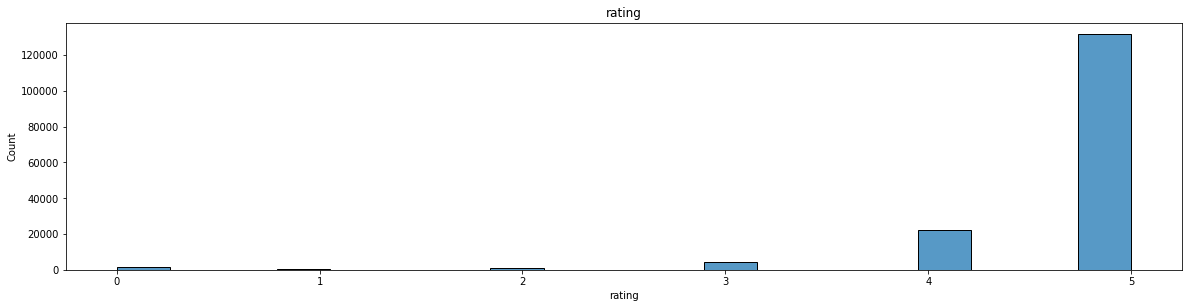

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(data=data_final, x="rating")
plt.title('rating')

We visualize the best recipes according to the average vote.


In [ ]:
best_recipes = data_final.sort_values('rating', ascending=False)
best_recipes[['name', 'rating']].head(15)

,name,rating
0,flank steak with lime chipotle sauce,5.0
87522,smoky tuna salad,5.0
87616,country dijon sausage pie,5.0
87615,chinese drunken prawns,5.0
87614,super sauted summer squash,5.0
87613,lemon spice puffs,5.0
87612,lima beans with cheese,5.0
87611,the best cherry cheesecake,5.0
87610,christmas fudge cookies,5.0
87609,quickie cinnamon rolls,5.0


## Content based recommender systems
Another way to create a recommender system is to base the recommendations on the content.
It is an exciting way to start a recommender system when we do not have many user interactions or new items to recommend.

### Steps
Here, we will use the steps of the recipes. We compute a TF-IDF matrix with the steps of the recipes (since colab has limited RAM, we will also work on a subset of the dataset using only the recipes that were submitted after 2012). 

In [ ]:
data_final['steps'] = data_final['steps'].fillna('')
subset = data_final[data_final['submitted'] > "2012"].reset_index()
subset['steps'].head()

0    ['mix all ingredients', 'sprinkle on beef , ch...
1    ['1', 'cook chicken in large frying pan', '2',...
2    ['bring the chicken broth to a boil in a sauce...
3    ['mix everything above in a medium bowl until ...
4    ['preheat oven to 400f', 'slice baguette into ...
Name: steps, dtype: object

In [ ]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('wordnet')
nltk.download('stopwords')
# Download stopwords list
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

# Interface lemma tokenizer from nltk with sklearn
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

# Lemmatize the stop words
tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))

# Create TF-idf model
tfidf = TfidfVectorizer(stop_words=token_stop, tokenizer=tokenizer, max_features=4000)

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(subset['steps'])



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now that we have a representation computed for each recipe, we can calculate distances or similarities for recipe pairs.
We compute the cosine similarity matrix of our TF-IDF Matrix. 

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(tfidf_matrix, tfidf_matrix)

We will create a list containig the recipes with the correct indexes to help us recommended recipes.

In [ ]:
names = subset['name']
indices = pd.Series(subset.index, index=subset['name'])
names[370:390]

370       harrington s favorite ham and cheese casserole
371                                cherry zucchini bread
372                                   brown sugar scones
373                              chicken kebabs shanghai
374                                 mel s infamous b l p
375                                     coconut oat bars
376                              indian brussels sprouts
377                    duck breasts with raspberry sauce
378              yoghurt filled capsicums   bell peppers
379              seared pork chops with creamy mushrooms
380                                   firecracker shrimp
381                  roasted carrots with smoked paprika
382    tomato and chicken rogan josh curry  pressure ...
383                             easy italian pasta salad
384                 coffee ice cream and cookie parfaits
385          sage rubbed pork chops with warm apple slaw
386                        huevos rancheros aussie style
387             weight watchers

We use the following function with our similarity matrix to recommend recipes from another recipe steps.

In [ ]:
def get_reco(title, sim_matrix):
  idx = indices[title]
  print(f'original: {title}')
  recos = sim_matrix[idx].argsort()[1:6]
  recos = names.iloc[recos]

  print(recos)

name = 'tallerina casserole 2'
get_reco(name, cosine_sim)

original: tallerina casserole 2
5162     georgian baked corn casserole
2584      chris s breakfast  casserole
675     dee s  swiss chicken casserole
5979     tuna noodle and pea casserole
5506                       oven nachos
Name: name, dtype: object


In [ ]:
del(cosine_sim)

### Description
In this part, we present another content based recommender system, this time by using the description of the of the recipes.

In [ ]:
tfidf = TfidfVectorizer(stop_words=token_stop, tokenizer=tokenizer, max_features=4000)
tfidf_matrix = tfidf.fit_transform(subset['description'])
cosine_sim = cosine_distances(tfidf_matrix, tfidf_matrix)

In [ ]:
names = subset['name']
indices = pd.Series(subset.index, index=subset['name'])
names[370:390]

370       harrington s favorite ham and cheese casserole
371                                cherry zucchini bread
372                                   brown sugar scones
373                              chicken kebabs shanghai
374                                 mel s infamous b l p
375                                     coconut oat bars
376                              indian brussels sprouts
377                    duck breasts with raspberry sauce
378              yoghurt filled capsicums   bell peppers
379              seared pork chops with creamy mushrooms
380                                   firecracker shrimp
381                  roasted carrots with smoked paprika
382    tomato and chicken rogan josh curry  pressure ...
383                             easy italian pasta salad
384                 coffee ice cream and cookie parfaits
385          sage rubbed pork chops with warm apple slaw
386                        huevos rancheros aussie style
387             weight watchers

In [ ]:
name = 'tallerina casserole 2'
get_reco(name, cosine_sim)

original: tallerina casserole 2
3921                                 dees greek omelet
2786    mango   avocado spring rolls with peanut sauce
1189                  braised sea bass w olives  zwt 8
2431                           moroccan vegetable soup
3341           moroccan olive omelette  bayd de zaitun
Name: name, dtype: object


We constate that the recommendations using the recipe steps and the description of the same recipe are different. 

In [ ]:
del(cosine_distances)
del(tfidf_matrix)

# Part 2: Sentiments analysis

In this part, we will train a model to predict if a user loved a recipe or not based on his comment. For that, we will use the data set Raw_interactions.

In [30]:
raw_interactions = pd.read_csv('RAW_interactions.csv')
raw_interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


We check if there are missing values and treat them.

In [31]:
raw_interactions.isna().sum()

user_id        0
recipe_id      0
date           0
rating         0
review       169
dtype: int64

In [32]:
raw_interactions.dropna(inplace=True)

## EDA
We start by some exploratory data analysis. 

Let's have a look in the reviews for each rate by taking randomly 10 samples.

In [33]:
raw_interactions[raw_interactions['rating']==0].review.sample(10).values

array(['This does not look like it is cooked at all after 40 mins at 300 not sure why but I put it back in. Did anyone else have this problem?',
       'I have this very recipe in an old cookbook of mine from 1947.',
       'I made this today......and am still shocked at how good my stew was.  I\'ve made every stew I could find over the course of 45  years, and never got that "perfect" taste that I was looking for.....until today.!!!  I can\'t believe that it uses a beer that I don\'t even like and turned out so good. (I didn\'t use 1/2 cup, just poured in the whole bottle.)<br/>I browned the meat and onions on the stove,(I did lightly dust the meat with some flour before browning,  made the broth, and poured into my crockpot.   I think that helped thicken the broth a bit.<br/>Then I added the sliced carrots, some celery and stirred them into the pot.Since my DH likes a little heat to his stew, I added about 1/2 jalapeno pepper.<br/>After the stew had cooked for one hour, I added cubed

The rating 0 is is ambigious we can't admit that they are negative. The majority of the reviews from the ten examples seems positive in general, so if we consider rating <=  3 as negative we would make a mistake here, we have no idea what 0 rating means in this case, is it neutral or positive or negative.

We might remove the reviews with rating 0.

Let's continue now with the rest of the ratings's reviews.

In [34]:
raw_interactions[raw_interactions['rating']==1].review.sample(10).values

array(['81g of fat is not "LOW Fat"',
       'this was horrible! it tasted too much like ketchup',
       'These might be &quot;egg rolls&quot;, but they&#039;re about as far from yakimandu as chinese fortune cookies.&lt;br/&gt;Edit: btw, since the entire internet apparently has no idea, I&#039;ll clue you in, you dont use egg roll wraps for dumplings (which is what yaki-mandu is..., if anyone ever bothered to look them up.) So, you&#039;re quite literally making egg rolls with this recipe. Which is of course, NOT yaki-mandu. So, all the reviewers saying this is like actual Korean food, or so on, idk who&#039;s lying to who; most of these ingredients arent even in traditional yaki-mandu.',
       "We didn't like these very much.  They had a rubbery texture, and not much flavor.  Very healthy, but not our favorite.",
       'So sorry to give a low review but considering no one in my family liked them I had to do it. Even my daughter was making faces during dinner. I ended up tossing the

The reviews with rating 1 are clearly negative so there no doubt about their rating !

In [35]:
raw_interactions[raw_interactions['rating']==2].review.sample(10).values

array(['The bread turned out very mushy on the bottom. Uck!',
       'Was expecting more. Perhaps adding some tomato sauce or a jalapeno would have improved it, but the meat was missing something.',
       'Thanks for sharing, Lynn.  This would require a lot of tweaking to suit our taste, but there are too many strong ingredients for me to try to adjust the balance among them.   I let it sit, then, for a week or so to marry the flavors but to no avail.  If I were to try again, I&#039;d cut way back on garlic and increase the oil to form an emulsion.  I&#039;ll report back if I try;  just hate to give up on a good idea.  I really appreciate your posting this recipe, though.',
       "It was okay - nothing too special.  The recipe was exceedingly sweet.  That being said, the pork chops came out very well - moist, yet still firm, and the sauce was tasty.  Think of this more as a sweet and sour pork, and you'll be fine.  Just wasn't what I was expecting.  Overall, I may make again, but not

The reviews with rating equals to 2 seem negative too !

In [36]:
raw_interactions[raw_interactions['rating']==3].review.sample(10).values

array(['These are good, will try again. Served with some Spanish Rice and spicy pinto beans.',
       'Wonderful taste, but I had the problem of them spreading to thin, like the other reviewer.',
       'This was an easy fix meal.\r\nHowever it was bland and too much juice from the salsa.\r\nBut it was still good.',
       'I have made this twice now and each time the dough was too sticky to use.  I had to add a bunch more flour before I was able to roll out the dough.  It was kind of a hassle.',
       'Since I do not have a slowcooker, I baked this in a waterbath at 375 for 45 minutes, removed 1 cup liquid and added 1/2 cup egg whitesto ensure it would set. It turned out wonderful, although a little heavy on the burbon for my tastes. The Thanksgiving guests loved it though, and the modified recipe has been passed on!',
       'I dont know what went wrong, but it was VERY thick and lumpy.  The flavor was excellent, and my family loved it!  But how do you keep it from lumping?',
      

The reviews with rating 3 looks neutral!

In [37]:
raw_interactions[raw_interactions['rating']==4].review.sample(10).values

array(['This made for a wonderful side to go with my pork tenderloin.  I especially enjoyed the sweet and tangy flavor of the brown sugar and vinegar.  I used Splenda brown sugar.  I subbed regular cabbage for the red cabbage because that was what I had on hand.  I thought I had rotini pasta, but I was all out so I subbed no yolk egg noodles.  Made for Honor Thy Mother - and be Gluten-Free, too! Tag Game.',
       "I had to use canned beets, because the beets at the store didn't look to happy!  This turned out really well none the less...I cannot wait to make them with raw beets too!  I will update once that happens!",
       "We really enjoyed this recipe.  We weren't able to use the slow cooker because we needed the recipe sooner.  We added margarine to it, because we felt it needed a little something more for the oven.  We baked it at 350 for about 45-50 minutes.",
       'I love cheating so this suited me down to the ground !! Quick and easy and great on my tuna salad. Made and enj

In [38]:
raw_interactions[raw_interactions['rating']==5].review.sample(10).values 

array(["MG, I love greens too, I should have been born in the South.  I used fresh escarole and caugt it at the right time because it wasn't to bitter either.  And I made some with the vinegar and some with lemon juice, I prefer them both :-) Thanks for an easy, delicious recipe.    ",
       'FINALLY!! THANK YOU!!! REAL SPANISH GAZPACHO! MMMMMM!!!!!!!\nI went to school in Seville and have been craving gazpacho ever since, but no restaurants here make it right! This brought me straight back to Spain! So light, yet creamy and VERY EASY to make! I had 2 bowls with fresh bread to dip before I could even let it get cold. Excellente!!! Gracias!',
       'This chicken was absolutely delicious!  The coating made the chicken nice and crisp on the outside and moist and tender on the inside.  The seasonings and gravy were really flavorful.  I will make this again, thanks Nimz!  I made this for Spring PAC 2009.',
       "I made these earlier today and I'm positive they will be on my cookie trays 

The reviews with rating > 3 are clearly positive reviews!

Before going any further we remove the rate 0 because it's confusing.

In [39]:
raw_interactions = raw_interactions[raw_interactions['rating']!=0] 

In [40]:
raw_interactions.shape 

(1071351, 5)

Now we visualize the distribution of the ratings in the data.

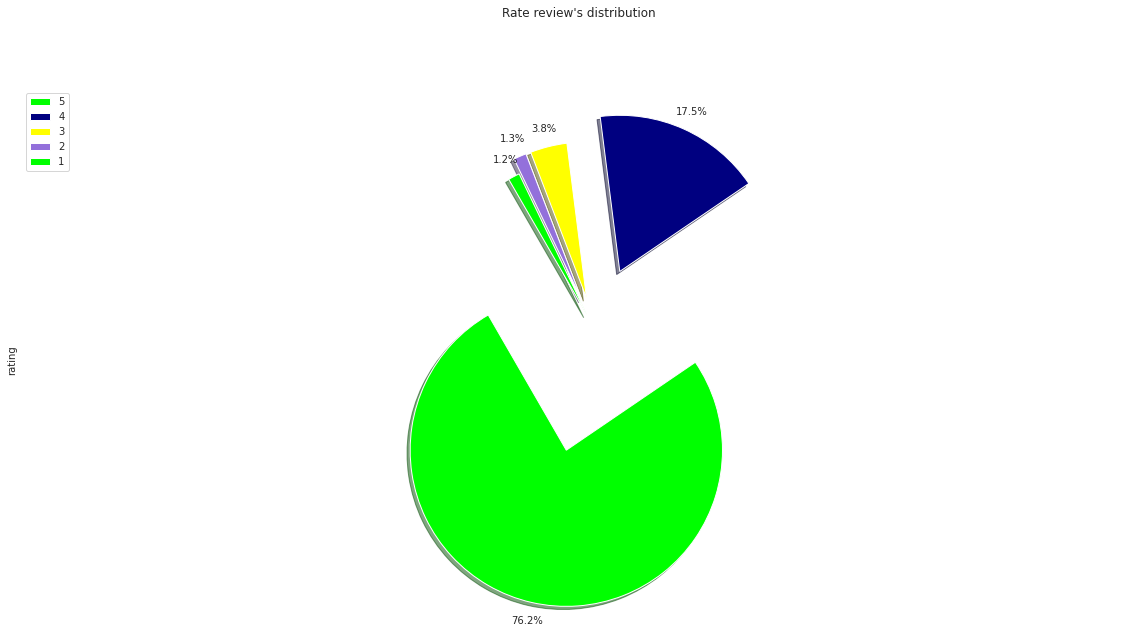

In [41]:
colors_list = ["lime","navy","yellow","mediumpurple"]
explode_list = [0.8, 0.4, 0.2, 0.2, 0.1] 
raw_interactions.rating.value_counts().plot(kind='pie',
                            figsize=(20, 10),
                            autopct='%1.1f%%', 
                            startangle=120,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )
# scale the title up by 12% to match pctdistance
plt.title("Rate review's distribution", y=1.12) 
plt.axis('equal') 
# add legend
plt.legend(labels=raw_interactions.rating.value_counts().index, loc='upper left') 
plt.show()

The majority of reviews are of rate 5 with more than 76 % followed by the rate 4 with a pourcentage of 17.5 %.

We have clearly an umbalanced classification problem because the positive rates are more than 93 % ! 
 
Let's have a look in our textual data and the most frequent words using wordcloud visualizations for each rate. Word cloud shows the words with a size that is proportionnal to their frenquancy on the corpus of data.

In [17]:
## plot wordcloud with or without mask/ stopwords 
def plot_wordcloud(df, rate, text_col, rate_col, stopwords=None, mask=None):

    all_words = []

    all_words = ' '.join([text for text in df[df[rate_col]==rate][text_col]])

    wordcloud = WordCloud(width=800,height=500,random_state=21,collocations=False,stopwords=stopwords,mask=mask,
                  max_font_size=110, background_color="black").generate(str(all_words))
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

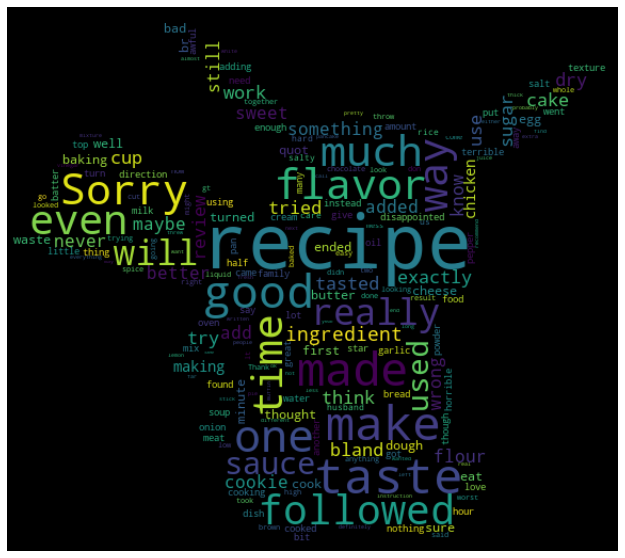

In [18]:
plot_wordcloud(raw_interactions, 1, 'review', 'rating', mask = np.array(Image.open("picatcho.png"))) 

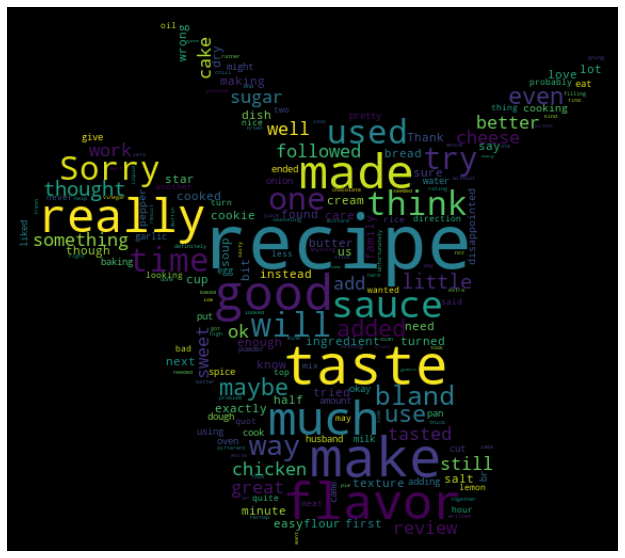

In [19]:
plot_wordcloud(raw_interactions, 2, 'review', 'rating', mask = np.array(Image.open("picatcho.png"))) 

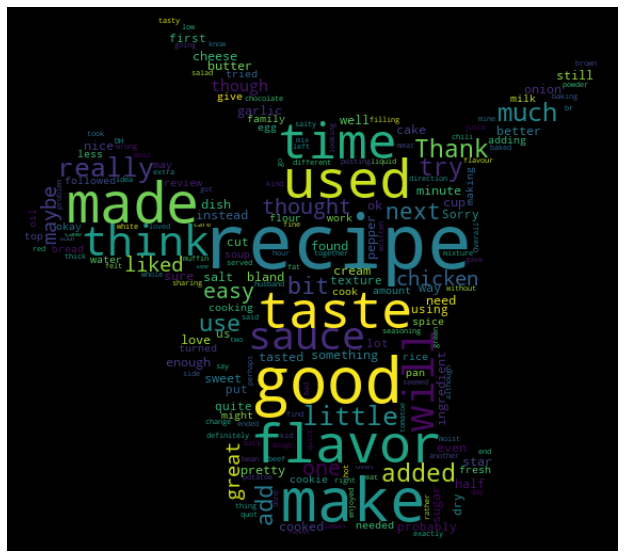

In [20]:
plot_wordcloud(raw_interactions, 3, 'review', 'rating', mask = np.array(Image.open("picatcho.png"))) 

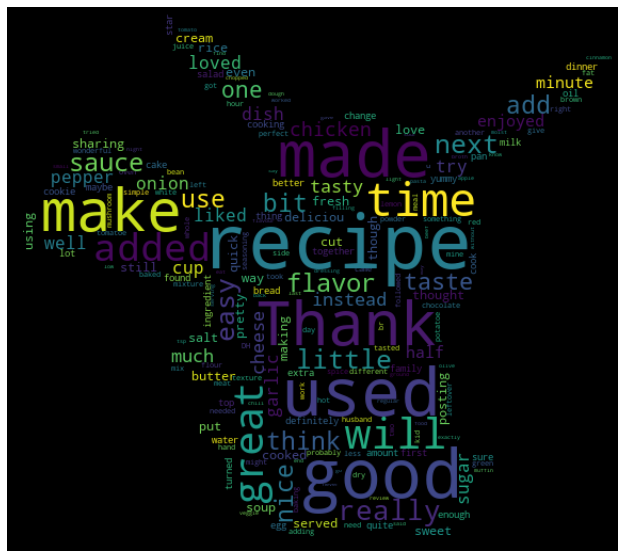

In [21]:
plot_wordcloud(raw_interactions, 4, 'review', 'rating', mask = np.array(Image.open("picatcho.png"))) 

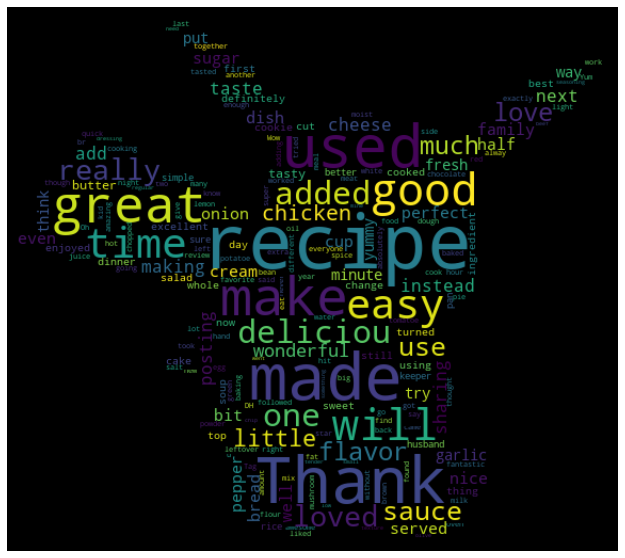

In [22]:
plot_wordcloud(raw_interactions, 5, 'review', 'rating', mask = np.array(Image.open("picatcho.png"))) 

## Preprocessing
We split our data before starting the preprocessing of the textual data.

In [42]:
## split data into train and test 
train, test, train_index, test_index = model_selection.train_test_split(raw_interactions, raw_interactions.index, 
                                                                        test_size=0.25,stratify=raw_interactions['rating'], random_state=2022)

Now we splitted the data, we will clean our text by removing noisy features like punctuations, links, caracteres that won't help in our classification task and it will even disturb the models in its learning, beside the fact that less words we have smaller the vocabulary we will build and hence the models will train faster.

For the stopwords we won't remove all of them, some of the stopwords will be usefull like don't, didn't, etc. For instance i didn't like the recipe and i like the recipe have opposite meaning and if we remove stopwords we will have the same phrase as result !

We use lemmitization as well to reduce the size of our vocabulary

In [43]:
custom_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 
"you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he',
'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its',
'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about',
'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to',
'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few',
'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'should', "should've",
'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain','ma', 'mightn', "mightn't", 'mustn', 'shan',
"shan't", 'wasn']

In [44]:
def preprocess_text(text,lemm=True):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = str(text).lower() ## Make text lowercase
    text = re.sub('\[.*?\]', '', text) # remove text in square brackets 
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove links 
    text = re.sub('<.*?>+', '', text) 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub('\n', '', text) 
    text = re.sub('\w*\d\w*', '', text)
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## Lemmatisation (convert the word into root word)
    if lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [45]:
train['clean_review'] = train['review'].progress_apply(preprocess_text)
test['clean_review'] = test['review'].progress_apply(preprocess_text)
train.head()

100%|██████████| 267838/267838 [01:13<00:00, 3649.47it/s]


,user_id,recipe_id,date,rating,review,clean_review
613839,1831591,253764,2012-02-13,5,I served these to company using heirloom tomat...,i served these to company using heirloom tomat...
888000,193516,26643,2007-05-12,5,These pancakes were very quick to make and del...,these pancake were very quick to make and deli...
676812,522099,125195,2008-06-30,5,I like trying different versions of a favorite...,i like trying different version of a favorite ...
1068654,400420,30018,2008-02-25,4,This was great! I left out the green beans - ...,this wa great i left out the green bean just f...
347414,126440,225907,2011-01-28,5,I made half a recipe of the fry bread and it w...,i made half a recipe of the fry bread and it w...


In [46]:
## removing stopwords 
def remove_stopwords(text, stopwords=custom_stopwords):
    text = ' '.join(word for word in text.split(' ') if word not in stopwords)
    return text

In [47]:
train['clean_review'] = train['clean_review'].progress_apply(remove_stopwords)
test['clean_review'] = test['clean_review'].progress_apply(remove_stopwords)
train.head()

100%|██████████| 267838/267838 [00:25<00:00, 10567.51it/s]


,user_id,recipe_id,date,rating,review,clean_review
613839,1831591,253764,2012-02-13,5,I served these to company using heirloom tomat...,served company using heirloom tomato excellent...
888000,193516,26643,2007-05-12,5,These pancakes were very quick to make and del...,pancake quick make delicious nice fluffy thick...
676812,522099,125195,2008-06-30,5,I like trying different versions of a favorite...,like trying different version favorite salad s...
1068654,400420,30018,2008-02-25,4,This was great! I left out the green beans - ...,wa great left green bean forgot added cup mush...
347414,126440,225907,2011-01-28,5,I made half a recipe of the fry bread and it w...,made half recipe fry bread wa great used lefto...


For cpu ressources limits we take only 40000 samples randomly from our data to do some statistical analysis to have an idea about the most important words for each class and the words the most correlated to each other in each rate. 

We encode the text using bag of words approach in particular tfidf that allows us to have a numeric representation of the phrases. 

We use chi square test to compute the correlation between the words and also select the words the most important for each rate.

In [48]:
## Let's take a sample from training data to do some statistics in the data to see the correlation between the words and the words the most important for each rating 
sample_train = train.sample(20000)

In [49]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(sample_train['clean_review']).toarray()
labels = sample_train['rating']
N = 2
for classe in sorted(sample_train.rating.unique()):
      features_chi2 = feature_selection.chi2(features, labels == classe)
      indices = np.argsort(features_chi2[0])
      feature_names = np.array(tfidf.get_feature_names())[indices]
      unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
      bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
      print("# '{}':".format(classe))
      print("Les unigrames les plus corrélées:\n. {}".format('\n. '.join(unigrams[-N:])))
      print("Les bigrams les plus corréllées:\n. {}".format('\n. '.join(bigrams[-N:])))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# '1':
Les unigrames les plus corrélées:
. terrible
. worst
Les bigrams les plus corréllées:
. wa terrible
. even close


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# '2':
Les unigrames les plus corrélées:
. bland
. sorry
Les bigrams les plus corréllées:
. thanks anyway
. sorry not


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# '3':
Les unigrames les plus corrélées:
. lacked
. ok
Les bigrams les plus corréllées:
. nothing spectacular
. wa ok


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# '4':
Les unigrames les plus corrélées:
. next
. pretty
Les bigrams les plus corréllées:
. next time
. pretty good
# '5':
Les unigrames les plus corrélées:
. maybe
. bland
Les bigrams les plus corréllées:
. wa ok
. pretty good


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [50]:
## Select the corpus of text from training data 
corpus = sample_train['clean_review']
# fit the tfidf in our corpus data
tfidf.fit(corpus)
## Trasform our text into numercal representation ussing fitted tfidf 
X = tfidf.transform(corpus)
## get our created vocabulary 
dic_vocabulary = tfidf.vocabulary_

In [51]:
## let's see the index of the word good for example 
word = "good"
dic_vocabulary[word]

6608

In [52]:
## as we see in our dictionnary vocabulary we have for each word a corresponding index
## a word in tfidf approch migh be a combinaison of two words as we specified in the parametre of our tfidf class ( ngram_range)
dic_vocabulary

{'made': 9549,
 'today': 17199,
 'church': 2727,
 'wa': 18410,
 'success': 15920,
 'make': 9894,
 'modification': 10768,
 'dish': 4286,
 'though': 16917,
 'used': 17924,
 'penne': 12244,
 'pasta': 12183,
 'instead': 8022,
 'didnt': 4053,
 'tomato': 17250,
 'sauce': 14361,
 'oz': 12020,
 'spaghetti': 15452,
 'everyone': 5133,
 'enjoyed': 4906,
 'left': 8602,
 'family': 5376,
 'home': 7568,
 'made today': 9837,
 'wa success': 18695,
 'make modification': 10041,
 'though used': 16939,
 'used penne': 18125,
 'penne pasta': 12245,
 'didnt tomato': 4126,
 'tomato sauce': 17280,
 'sauce used': 14466,
 'used oz': 18112,
 'spaghetti sauce': 15454,
 'sauce instead': 14409,
 'everyone enjoyed': 5139,
 'make family': 9968,
 'tasty': 16419,
 'good': 6608,
 'gave': 6379,
 'jar': 8225,
 'christmas': 2711,
 'also': 539,
 'received': 13388,
 'not': 11311,
 'reviewing': 13978,
 'sooner': 15340,
 'thought': 16942,
 'submitted': 15902,
 'review': 13946,
 'must': 10986,
 'lol': 9155,
 'recipe': 13393,
 'ex

In [53]:
## size of our vocabulary 
len(dic_vocabulary)

19757

We use again the chi square test to get the most important words in each class, where we set the p_value to 0.05. The null hypothesis here is to suppose that the word is indepandant from the class in question.

In [54]:
## get the words
X_names = tfidf.get_feature_names()
## set the p_value at 0.05 
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(sample_train['rating']):
    chi2, p = feature_selection.chi2(X, sample_train['rating'].values==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y_train":cat}))
    dtf_features = dtf_features.sort_values(["y_train","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [55]:
## for each class return the first 10 most important words 
for cat in np.unique(dtf_features["y_train"]):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtf_features[dtf_features["y_train"]==cat]))
    print("  . top features:", ",".join(
dtf_features[dtf_features["y_train"]==cat]["feature"].values[:10]))
    print(" ")

# 1:
  . selected features: 400
  . top features: awful,even close,gross,horrible,sorry,terrible,waste,worst,wa terrible,waste time
 
# 2:
  . selected features: 387
  . top features: sorry,sorry not,bland,thanks anyway,wa bland,sorry say,wa disappointed,tasted ok,tried not,expected wa
 
# 3:
  . selected features: 387
  . top features: ok,wa ok,lacked,okay,bland,nothing spectacular,wa okay,good nothing,high hope,nothing special
 
# 4:
  . selected features: 168
  . top features: pretty good,next time,pretty,next,good,wa good,liked,wa pretty,nice,bit
 
# 5:
  . selected features: 363
  . top features: bland,pretty good,maybe,wa ok,sorry,pretty,delicious,would,wa pretty,not
 


After exploring a little bit our textual data we are going now to implement our models based on different approachs from vectorization point of view. 

We start first by the bag of words approach using tfidf method that is simple to implement but also efficient, and then we implement some more advanced approach when we will train our model in embedding vectors using Glove method developped by stanford and we finish our work with the state of art of methods using the language model approach in particular trasformers.

## Models

### Bag of words (TF-IDF)

In [56]:
train.head()

,user_id,recipe_id,date,rating,review,clean_review
613839,1831591,253764,2012-02-13,5,I served these to company using heirloom tomat...,served company using heirloom tomato excellent...
888000,193516,26643,2007-05-12,5,These pancakes were very quick to make and del...,pancake quick make delicious nice fluffy thick...
676812,522099,125195,2008-06-30,5,I like trying different versions of a favorite...,like trying different version favorite salad s...
1068654,400420,30018,2008-02-25,4,This was great! I left out the green beans - ...,wa great left green bean forgot added cup mush...
347414,126440,225907,2011-01-28,5,I made half a recipe of the fry bread and it w...,made half recipe fry bread wa great used lefto...


We consider the rating less than 3 as negative and the greater or equal as positve reviews.

In [57]:
train['rate'] = train['rating'].apply(lambda x : 1 if x >2 else 0)
test['rate'] = test['rating'].apply(lambda x : 1 if x >2 else 0)
train.head()

,user_id,recipe_id,date,rating,review,clean_review,rate
613839,1831591,253764,2012-02-13,5,I served these to company using heirloom tomat...,served company using heirloom tomato excellent...,1
888000,193516,26643,2007-05-12,5,These pancakes were very quick to make and del...,pancake quick make delicious nice fluffy thick...,1
676812,522099,125195,2008-06-30,5,I like trying different versions of a favorite...,like trying different version favorite salad s...,1
1068654,400420,30018,2008-02-25,4,This was great! I left out the green beans - ...,wa great left green bean forgot added cup mush...,1
347414,126440,225907,2011-01-28,5,I made half a recipe of the fry bread and it w...,made half recipe fry bread wa great used lefto...,1


In [58]:
## get target
X_train = train['clean_review']
y_train = train["rate"].values

x_test = test['clean_review']
y_test = test["rate"].values

In [59]:
# Always using tfidf to encode our textual data 
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
corpus = X_train
tfidf.fit(corpus)
X_train = tfidf.transform(corpus)
dic_vocabulary = tfidf.vocabulary_

We use chi squared test to build our vocabulary with only the most important words.

In [60]:
X_names = tfidf.get_feature_names()
p_value_limit = 0.95
dffeatures = pd.DataFrame()
for cat in np.unique(y_train):
    chi2, p = feature_selection.chi2(X_train, y_train==cat)
    dffeatures = dffeatures.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y_train":cat}))
    dffeatures = dffeatures.sort_values(["y_train","score"], 
                    ascending=[True,False])
    dffeatures = dffeatures[dffeatures["score"]>p_value_limit]
X_names = dffeatures["feature"].unique().tolist()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [61]:
len(X_names)

13452

We reduced the number of features from 37667 to 13452 by keeping the most statistically relevant ones.

In [62]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
#X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [63]:
X_train = train['clean_review']
y_train = train["rate"].values

In [64]:
train_features = vectorizer.transform(X_train)
test_features = vectorizer.transform(x_test)

In [65]:
train_features.shape

(803513, 13452)

In [66]:
models = [
    MultinomialNB(),
    LogisticRegression(random_state=2021, class_weight = 'balanced',n_jobs=-1), 
    LinearSVC(class_weight ='balanced'),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in tqdm(models):
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, train_features, y_train, scoring='f1_weighted', cv=CV, n_jobs=-1)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_weighted'])

100%|██████████| 3/3 [14:17<00:00, 285.78s/it]


In [67]:
cv_df.groupby('model_name').f1_weighted.mean()

model_name
LinearSVC             0.945010
LogisticRegression    0.945803
MultinomialNB         0.967166
Name: f1_weighted, dtype: float64

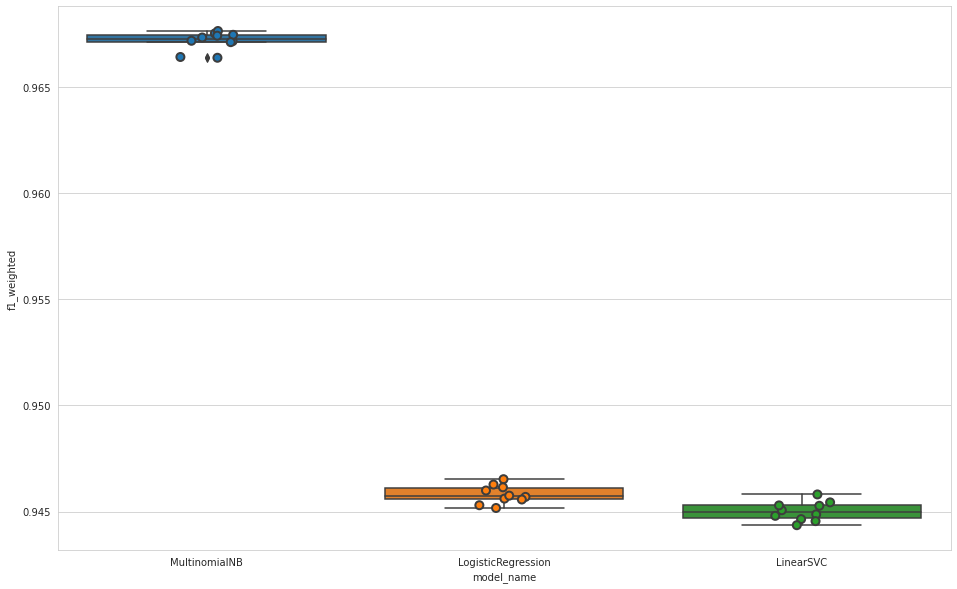

In [68]:
sns.boxplot(x='model_name', y='f1_weighted', data=cv_df)
sns.stripplot(x='model_name', y='f1_weighted', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [69]:
MNB = MultinomialNB(alpha=0.7)
MNB.fit(train_features, y_train)
predictions_MNB = MNB.predict(test_features)
print(classification_report(y_test, predictions_MNB))

              precision    recall  f1-score   support

           0       0.89      0.10      0.19      6735
           1       0.98      1.00      0.99    261103

    accuracy                           0.98    267838
   macro avg       0.93      0.55      0.59    267838
weighted avg       0.98      0.98      0.97    267838



In [70]:
svm = LinearSVC(class_weight ='balanced',random_state=2022, C=5)
svm.fit(train_features, y_train)
predictions_svm = svm.predict(test_features)
print(classification_report(y_test, predictions_svm))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


              precision    recall  f1-score   support

           0       0.24      0.93      0.38      6735
           1       1.00      0.92      0.96    261103

    accuracy                           0.92    267838
   macro avg       0.62      0.93      0.67    267838
weighted avg       0.98      0.92      0.95    267838



In [71]:
LR = LogisticRegression(random_state=2021, class_weight = 'balanced',n_jobs=-1)
LR.fit(train_features, y_train)
predictions_LR = LR.predict(test_features)
print(classification_report(y_test, predictions_LR))

              precision    recall  f1-score   support

           0       0.24      0.93      0.38      6735
           1       1.00      0.92      0.96    261103

    accuracy                           0.93    267838
   macro avg       0.62      0.93      0.67    267838
weighted avg       0.98      0.93      0.95    267838



The naive bayes model have a good precision but bad recall, whereas the linear models linear regression and svm have a good recall but bad precision, we may ensemble the models to have a better trade-off between recall and precision, but we won't go any further we will just try to see now how we can explain the predictions of the best model in our case in bayes model using lime.

It is time now to apply LimeTextExplainer function to generate local explanations for predictions. The function needs as parameters the question to explain (of index 1300), the predicted label of the question generated from the black box model (the logistic regression), and the number of features used for explanation.

In [72]:
idx =test.index[1300]
c = make_pipeline(vectorizer,MNB)
class_names = ["negative", "positive"]
explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(test["clean_review"][idx], c.predict_proba, num_features = 10)

print("review: \n", test["clean_review"][idx])
print("Probability (positive) =", c.predict_proba([test["clean_review"][idx]])[0, 1])
print("Probability (Negative) =", c.predict_proba([test["clean_review"][idx]])[0, 0])
print("True Class is:", class_names[test["rate"][idx]])

review: 
 great bread lovely dark brown color fine dense crumb substituted cup whole wheat pastry flour white flour substitution ratio found work best used dried cranberry rather raisin walnut nut not terribly sweet bread next time might add fruit bit add nice sweetness bread bread dense moist almost textured like fine cake definitely much healthier rose well really pretty loaf despite whole grain not dry dense crumbly youre right scrumptious
Probability (positive) = 0.9859413048099238
Probability (Negative) = 0.014058695190076952
True Class is: positive


The classifier got this example right.

The explanation is presented below as a list of weighted features.

In [73]:
exp.as_list() 

[('dense', -0.013551296053781883),
 ('scrumptious', 0.012000447141697556),
 ('terribly', -0.008945139800733642),
 ('lovely', 0.008219644857524952),
 ('substituted', 0.007802452531993491),
 ('walnut', 0.0069581678598486215),
 ('cranberry', 0.006211965911861171),
 ('crumbly', -0.004678150773059999),
 ('ratio', -0.0034068599314499588),
 ('despite', -0.002658467679889443)]

The results can be shown in LIME in different types of visualization

In [74]:
exp.show_in_notebook(text=True) 

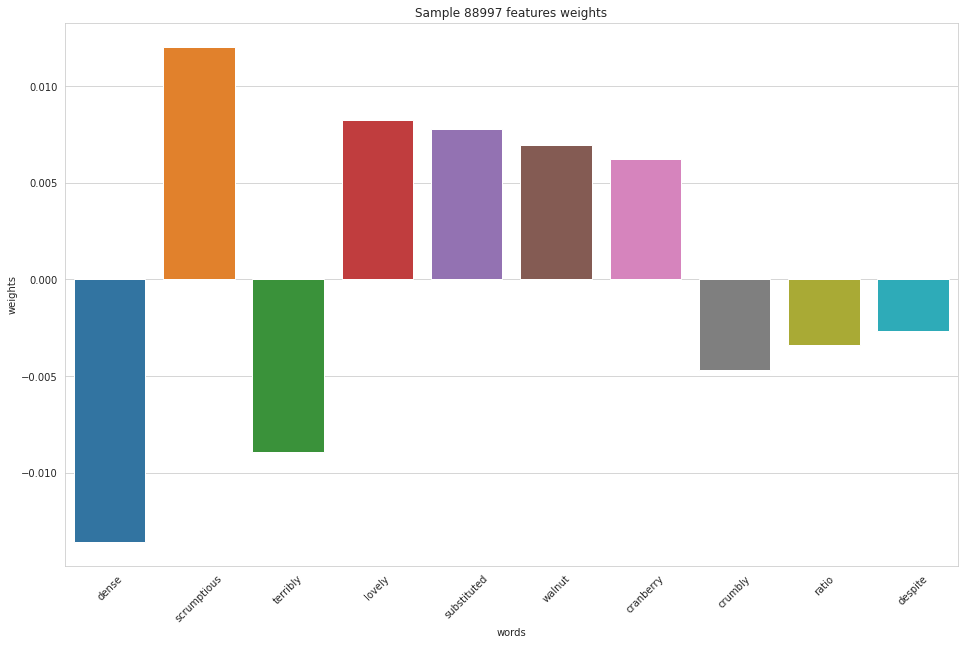

In [75]:
weights = OrderedDict(exp.as_list())
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 45)
plt.title("Sample {} features weights".format(idx))
plt.show()

In [ ]:
del dic_vocabulary, train_features, test_features, svm, LR, MNB, predictions_MNB, predictions_LR, predictions_svm

### Word Embedding : Word2Vec

Now we will jump into our second approach regarding the encoding of text using the library word2vec. 

Word2Vec creates a vector space, usually hundreds of dimensions, where each word in the corpus is unique, so words that share a common context in the corpus are closely arranged in the space. This can be done using two different methods: predicting its context starting from a single word (Skip-gram) or predicting a word starting from the context (Continuous Bag-of-Words).

Instead of using a pretrained model, we will use Gensim to adapt our own Word2Vec to a corpus of training data. Before fitting the model, the corpus must be transformed into a list of n-gram lists

In [76]:
train.head() 

,user_id,recipe_id,date,rating,review,clean_review,rate
613839,1831591,253764,2012-02-13,5,I served these to company using heirloom tomat...,served company using heirloom tomato excellent...,1
888000,193516,26643,2007-05-12,5,These pancakes were very quick to make and del...,pancake quick make delicious nice fluffy thick...,1
676812,522099,125195,2008-06-30,5,I like trying different versions of a favorite...,like trying different version favorite salad s...,1
1068654,400420,30018,2008-02-25,4,This was great! I left out the green beans - ...,wa great left green bean forgot added cup mush...,1
347414,126440,225907,2011-01-28,5,I made half a recipe of the fry bread and it w...,made half recipe fry bread wa great used lefto...,1


In [77]:
corpus = train["clean_review"]

lst_corpus = []

## create list of lists of unigrams
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

In [78]:
## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                  min_count=5, threshold=10) # delimiter=' '.encode(),
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
             min_count=5, threshold=10) # delimiter=" ".encode(),
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [79]:
np.mean([len(l)  for l in train['clean_review']]) 

174.05989448832813

When fitting the Word2Vec, the most important parametres are : 

. the target size of the word vectors, we use 300 as dimension

. the window, or the maximum distance between the current and predicted word within a sentence, we use here 8

. the training algorithm, we use skip-grams (sg=1) as in general it has better results as we saw in the litterature.

In [81]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,window=8, min_count=1, sg=1) 

In [82]:
word = "delicious"

## word embedding
_words = [word] + [tupla[0] for tupla in 
                 nlp.wv.most_similar(word, topn=20)]
                #model_w2v.wv[word].reshape((1, size)) 
x = nlp.wv[_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
x = pca.fit_transform(x)
## create dtf
df = pd.DataFrame(x, index=_words, columns=["x","y","z"])
df["input"] = 0
df["input"].iloc[0:1] = 1

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


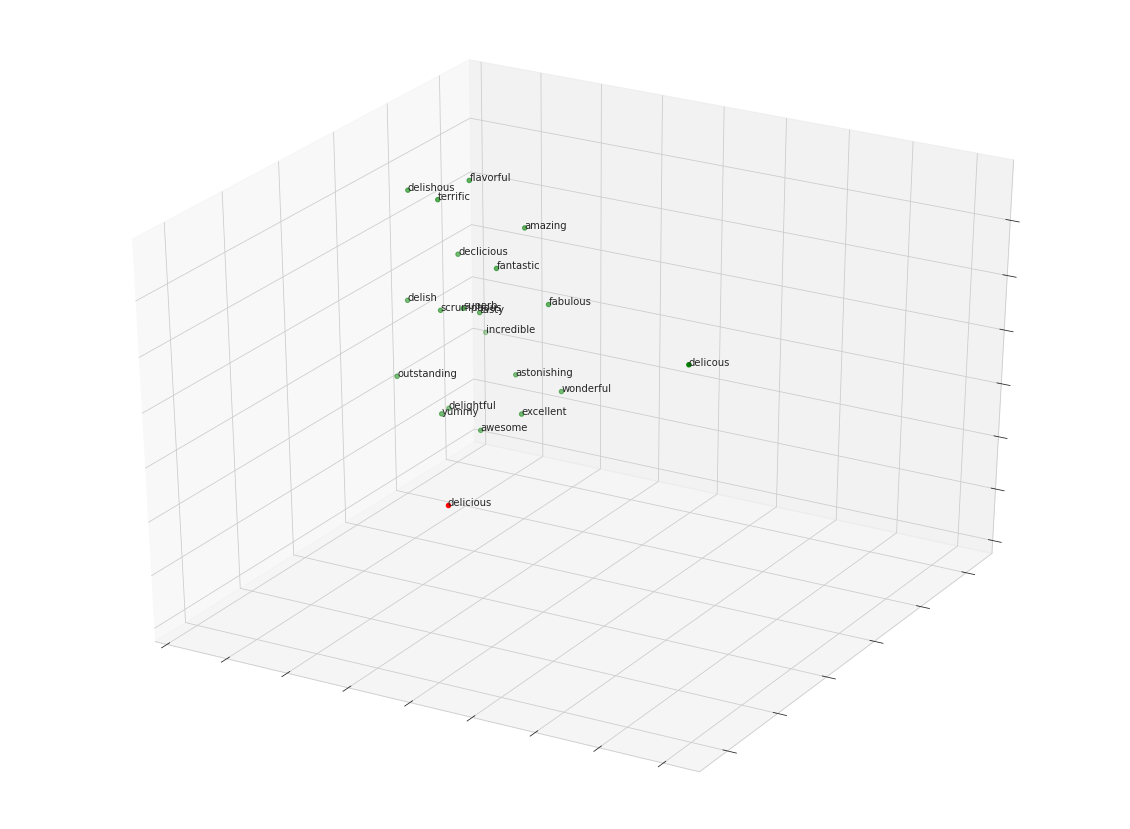

In [83]:
## plot 3d
fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[df["input"]==0]['x'], 
           df[df["input"]==0]['y'], 
           df[df["input"]==0]['z'], c="green")
ax.scatter(df[df["input"]==1]['x'], 
           df[df["input"]==1]['y'], 
           df[df["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in df[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

We can see that all the words that are close to delicious are positive and have almost a close meaning in our context of reviews like favorful, deeelish ... 

We transforme now the preprocessed corpus given to the Word2Vec into a list of sequences using keras:

In [84]:
## tokenization of the text 
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
## get the vocabulary 
dic_vocabulary = tokenizer.word_index

In [85]:
## create sequences
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [86]:
X_train.shape

(803513, 15)

The feature matrix X_train has a shape of 803513 x 15 (Number of sequences x Sequences max length)

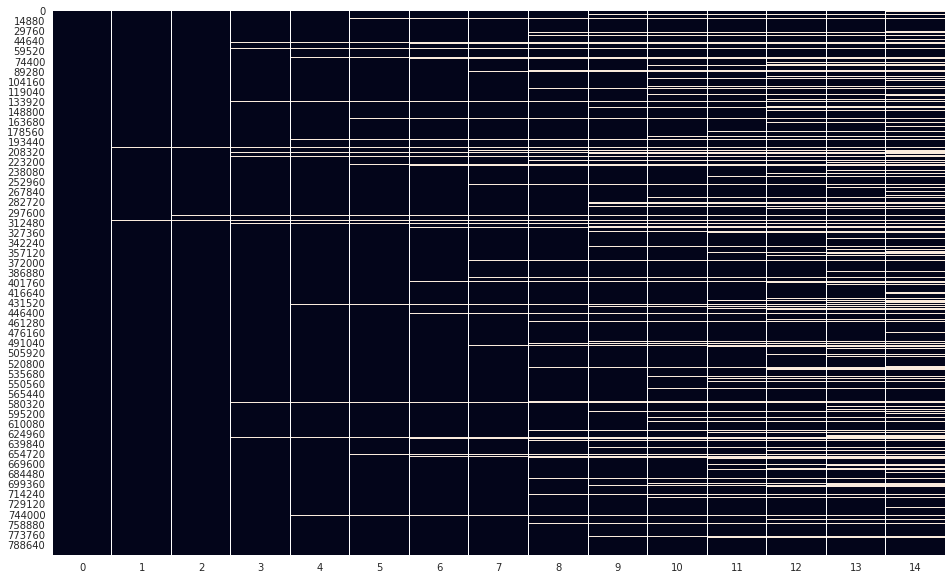

In [87]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

Every text in the corpus is now an id sequence with length 15

We do the same feature processing on the test set

In [88]:
corpus_test = test["clean_review"]
## create list of n-grams
lst_corpus = []
for string in corpus_test:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)

In [89]:
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

Now we got our input train and test sets-up, we need to create the matrix of embedding that will be used as a weight matrix in the neural network classifier( The words numercial representation)

In [90]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [91]:
embeddings.shape

(217184, 300)

In [92]:
del nlp

We have now a matrix of shape 217184 x 300 (size of vocabulary x Vector size).
 
It's finally the time now to start building our neural network. 

We will use the embedding matrix in the first embedding layer of the neural network. Each id in the input sequence is used as an index to access the embedding matrix

The neural network will be structured as follows  :

1) an Embedding layer that takes the sequences as input and the word vectors as weights, just as described before.

2) Two layers of Bidirectional LSTM to model the order of words in a sequence in both directions.

3) Two final dense layers that will predict the probability of the sentiment of a review.

In addition to our classical architecture we use some techniques like dropout to avoid overfitting, and we use cross entropy as a cost function. We use adam optimizer.

In [97]:
## Word embedding models 
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [98]:
## input
x_input = layers.Input(shape=(15,))

## embedding layer 
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_input)

# ## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2,return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)

## final dense layers
x = layers.Dense(64, activation='relu')(x)

# the output layer 
y_output = layers.Dense(1, activation='sigmoid')(x)


## compile
model = models.Model(x_input, y_output)
model.compile(loss='BinaryCrossentropy',optimizer='adam', metrics=['AUC'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 15, 300)           65155200  
                                                                 
 bidirectional_2 (Bidirectio  (None, 15, 30)           37920     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 30)               5520      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                1984      
                                                                 
 dense_3 (Dense)             (None, 1)                 65    

Now we can train the model and check the performance on a subset of the training set used for validation before testing it on the actual test set

In [99]:
## train the model with a batch size of 256 and shuffling samples 

training = model.fit(x=X_train, y=y_train, batch_size=256, epochs=5, shuffle=True, verbose=0,validation_split=0.25)

Text(0, 0.5, 'Loss')

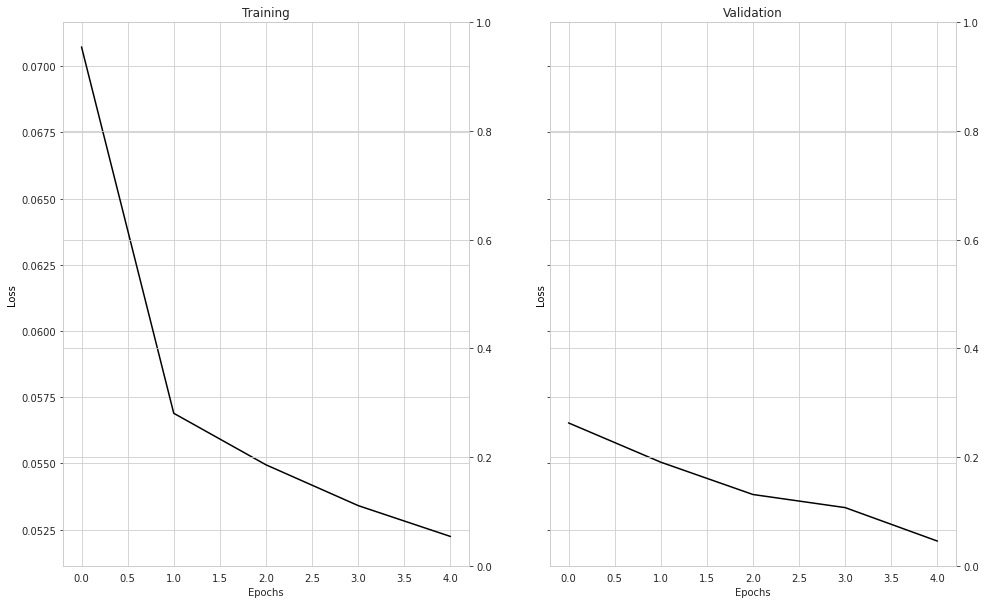

In [100]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')

In [101]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("AUC: %.2f%%" % (scores[1]*100))

AUC: 96.25%


Our LSTM model combined with the embedding representations gives better result than linear models with TF-IDF approach.

# Part 3: Neural collaborative filtering

In this part, we use the NCF (Neural Collaborative Filtering) class present in the TP on recommendation systems to train a Neural Collaborative Filtering model to predict a user's ratings.

Firstly, we consider the class Ratings_Dataset to convert our ratings datasets in Pytorch datasets.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class Ratings_Datset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index()

    def __len__(self):
        return len(self.df)
  
    def __getitem__(self, idx):
        user = user2id[self.df['user_id'][idx]]
        user = torch.tensor(user, dtype=torch.long)
        item = item2id[self.df['recipe_id'][idx]]
        item = torch.tensor(item, dtype=torch.long)
        rating = torch.tensor(self.df['rating'][idx], dtype=torch.float)
        return user, item, rating

We define the training method that we will use to train the network.

In [ ]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from statistics import mean


def train(model, optimizer, trainloader, epochs=30):
    criterion = nn.MSELoss(reduction='mean')
    t = tqdm(range(epochs))
    for epoch in t:
        corrects = 0
        total = 0
        train_loss = []
        for users, items, r in trainloader:
            users = users.cuda()
            items = items.cuda()
            r = r.cuda() / 5
            y_hat = model(users, items)
            loss = criterion(y_hat, r.unsqueeze(1).float())
            train_loss.append(loss.item())
            total += r.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f"loss: {mean(train_loss)}")

We use the following code to create an NCF network.


In [ ]:
class NCF(nn.Module):
        
    def __init__(self, n_users, n_items, n_factors=8):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)
        self.predictor = torch.nn.Sequential(
            nn.Linear(in_features=n_factors*2, out_features=64),
            nn.Linear(in_features=64, out_features=32),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )
        
        
    def forward(self, user, item):
        

        u = self.user_embeddings(user)
        i = self.item_embeddings(item)

        # Concat the two embedding layers
        z = torch.cat([u, i], dim=-1)
        return self.predictor(z)

Now, we train our NCF network on the train dataset and test it on the test dataset.

In [ ]:
user_list = train_final.user_id.unique()
item_list = train_final.recipe_id.unique()
user2id = {w: i for i, w in enumerate(user_list)}
item2id = {w: i for i, w in enumerate(item_list)}
trainloader = DataLoader(Ratings_Datset(train_final), batch_size=512, shuffle=True ,num_workers=2)

In [ ]:
n_user = train_final.user_id.nunique()
n_items = train_final.recipe_id.nunique()

In [ ]:
model = NCF(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
user_list = test_final.user_id.unique()
item_list = test_final.recipe_id.unique()
user2id = {w: i for i, w in enumerate(user_list)}
item2id = {w: i for i, w in enumerate(item_list)}
testloader = DataLoader(Ratings_Datset(test_final), batch_size=64, num_workers=2)

We will use the following code to evaluate our model.

In [ ]:
import math

def test(model, testloader, m_eval=False):

    
    running_mae = 0
    with torch.no_grad():
        corrects = 0
        total = 0
        for users, items, r in testloader:
            users = users.cuda()
            items = items.cuda()
            y = r.cuda() / 5
            y_hat = model(users, items).flatten()
            error = torch.abs(y_hat - y).sum().data
            
            running_mae += error
            total += y.size(0)
    
    mae = running_mae/total
    return mae * 5

In [ ]:
print('The mean absolute error is ', test(model, testloader))

The mean absolute error is  tensor(0.8222, device='cuda:0')


Below, we show some predictions of the model.

In [ ]:
users, recipes, r = next(iter(testloader))
users = users.cuda()
recipes = recipes.cuda()
r = r.cuda()

y = model(users, recipes)*5
print("ratings", r[:10].data)
print("predictions:", y.flatten()[:10].data)

ratings tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.], device='cuda:0')
predictions: tensor([4.7060, 4.7570, 4.7576, 4.7140, 4.6872, 4.7403, 4.8076, 4.8386, 4.7826,
        4.8294], device='cuda:0')


Finally, we save our network weights to a weight.pth file.

In [ ]:
torch.save(model.state_dict(), 'weights.pth')

# Part 4: Scripts

In this part we test our main.py script which uses the model NCF defined in the model.py script and the weights as a .pth file to run predictions on a file test_script.csv.

In [ ]:
!python main.py --weights='weights.pth' --test_data='test_script.csv'

ratings tensor([4., 4., 4., 4., 5., 5., 5., 4., 3., 5.], device='cuda:0')
predictions: tensor([4.7060, 4.7570, 4.7576, 4.7140, 4.6872, 4.7403, 4.8076, 4.8386, 4.7826,
        4.8294], device='cuda:0')
